In [2]:
import laspy
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

LAZ_FILE = "data/sample_roofdata_50/10444144.laz"  # bytt til en av dine filer


In [3]:
las = laspy.read(LAZ_FILE)
points = np.vstack([las.x, las.y, las.z]).T

print("Antall punkter:", points.shape[0])
points[:5]


Antall punkter: 1403


array([[5.70972360e+05, 7.03068684e+06, 9.79500000e+01],
       [5.70972150e+05, 7.03068637e+06, 9.81800000e+01],
       [5.70972530e+05, 7.03068567e+06, 9.85200000e+01],
       [5.70972300e+05, 7.03068518e+06, 9.87300000e+01],
       [5.70972100e+05, 7.03068474e+06, 9.89500000e+01]])

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.astype(np.float64))

# valgfritt: kjapp sjekk
o3d.visualization.draw_geometries([pcd])


In [33]:
# litt nedsampling for fart
pcd_seg = pcd.voxel_down_sample(voxel_size=0.1)
pcd_seg.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30)
)

max_planes = 5
min_points_per_plane = 50
distance_threshold = 0.15
ransac_n = 3
num_iterations = 1000

plane_models = []
plane_point_indices = []

pc = pcd_seg
points_all = np.asarray(pc.points)

for i in range(max_planes):
    if len(pc.points) < min_points_per_plane:
        break

    plane_model, inliers = pc.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )
    inliers = np.array(inliers)
    if inliers.size < min_points_per_plane:
        break

    plane_models.append(plane_model)        # a,b,c,d
    plane_point_indices.append(inliers)

    # fjern disse punktene og fortsett
    pc = pc.select_by_index(inliers, invert=True)

print(f"Fant {len(plane_models)} plan")


Fant 4 plan


In [34]:
def fit_plane_least_squares(points_xyz):
    """
    z = a*x + b*y + c
    """
    X = points_xyz[:, :2]
    Z = points_xyz[:, 2]
    A = np.c_[X, np.ones(len(X))]
    coef, *_ = np.linalg.lstsq(A, Z, rcond=None)
    a, b, c = coef
    return a, b, c

segmented_facets = []

for (A, B, C, D), idx in zip(plane_models, plane_point_indices):
    facet_pts = points_all[idx]  # (N,3)

    a, b, c = fit_plane_least_squares(facet_pts)

    # normalen til z = ax+by+c er (a, b, -1)
    n = np.array([a, b, -1.0])
    n = n / np.linalg.norm(n)
    slope_deg = np.degrees(np.arccos(abs(n[2])))

    segmented_facets.append({
        "points": facet_pts,
        "plane_abc": (a, b, c),
        "normal": n,
        "slope_deg": slope_deg,
    })

for i, f in enumerate(segmented_facets):
    print(f"Fasett {i}: helling ≈ {f['slope_deg']:.1f}°")

# filtrer: ikke helt flatt, ikke vertikalt
roof_facets = [f for f in segmented_facets if 5 <= f["slope_deg"] <= 80]
print("Takfasetter:", len(roof_facets))


Fasett 0: helling ≈ 0.3°
Fasett 1: helling ≈ 0.9°
Fasett 2: helling ≈ 1.1°
Fasett 3: helling ≈ 1.1°
Takfasetter: 0


In [41]:
from shapely.geometry import MultiPoint

for f in roof_facets:
    pts = f["points"]
    xy = pts[:, :2]

    # 1) convex hull i 2D
    hull_poly = MultiPoint(xy).convex_hull

    # 2) hvis ikke Polygon -> gjør den om til Polygon med liten buffer
    if hull_poly.geom_type != "Polygon":
        # liten buffer (0.2 m) for å gjøre LineString/Point til en smal polygon
        hull_poly = hull_poly.buffer(0.2, cap_style=2, join_style=2)

    f["footprint_2d"] = hull_poly

    # 3) løft polygonet til 3D med z = a*x + b*y + c
    a, b, c = f["plane_abc"]
    poly3d = []
    for x, y in hull_poly.exterior.coords:
        z = a * x + b * y + c
        poly3d.append((x, y, z))
    f["polygon_3d"] = poly3d

for i, f in enumerate(roof_facets):
    print(f"Fasett {i}: footprint-type={f['footprint_2d'].geom_type}, "
          f"hjørner={len(f['footprint_2d'].exterior.coords)}")


In [ ]:
print("Antall fasetter totalt:", len(segmented_facets))
for i, f in enumerate(segmented_facets):
    print(f"Fasett {i}: helling ≈ {f['slope_deg']:.1f}°")

print("Antall takfasetter etter filter:", len(roof_facets))


Antall fasetter totalt: 4
Fasett 0: helling ≈ 0.3°
Fasett 1: helling ≈ 0.9°
Fasett 2: helling ≈ 1.1°
Fasett 3: helling ≈ 1.1°
Antall takfasetter etter filter: 0


: 

In [44]:
from shapely.geometry import MultiPoint

# Samle ALLE takpunkter (fra alle fasetter)
all_roof_pts = np.vstack([f["points"] for f in roof_facets])
roof_xy_all = all_roof_pts[:, :2]

# 1) convex hull av alle takpunktene
base_hull = MultiPoint(roof_xy_all).convex_hull

# 2) sørg for at det er et Polygon (ikke LineString/Point)
if base_hull.geom_type != "Polygon":
    base_hull = base_hull.buffer(0.2, cap_style=2, join_style=2)

wall_base_poly = base_hull

print("Footprint-type for vegger:", wall_base_poly.geom_type)
print("Antall hjørner:", len(wall_base_poly.exterior.coords))

# --- HØYDER ---
ground_z = float(np.min(points[:, 2])) - 2.0
print("Estimert terrenghøyde:", ground_z)

edge_zs = []
for f in roof_facets:
    for x, y, z in f["polygon_3d"]:
        edge_zs.append(z)

avg_roof_edge_z = float(np.median(edge_zs))
print("Estimert takkant-høyde:", avg_roof_edge_z)

# --- GENERER VEGGER ---
wall_quads = []
coords2d = list(wall_base_poly.exterior.coords)

for i in range(len(coords2d) - 1):
    x1, y1 = coords2d[i]
    x2, y2 = coords2d[i + 1]
    quad = [
        (x1, y1, ground_z),
        (x1, y1, avg_roof_edge_z),
        (x2, y2, avg_roof_edge_z),
        (x2, y2, ground_z),
    ]
    wall_quads.append(quad)

print("Antall veggflater:", len(wall_quads))


ValueError: need at least one array to concatenate

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

colors = plt.cm.tab10(np.linspace(0, 1, len(roof_facets)))

# takfasetter
for f, col in zip(roof_facets, colors):
    poly3d = np.array(f["polygon_3d"])
    verts = [poly3d]  # én flate
    poly = Poly3DCollection(
        verts,
        facecolor=col,
        edgecolor="k",
        alpha=0.4,
        linewidths=0.5,
    )
    ax.add_collection3d(poly)

# vegger
for quad in wall_quads:
    q = np.array(quad + [quad[0]])  # lukk polygonet
    verts = [q]
    wall_poly = Poly3DCollection(
        verts,
        facecolor=(0.8, 0.8, 0.8, 0.2),
        edgecolor="k",
        linewidths=0.3,
    )
    ax.add_collection3d(wall_poly)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1, 1, 0.5])
plt.tight_layout()
plt.show()


Fant 0 møne/overgangslinjer (i 2D)


In [22]:
n_facets = len(roof_facets)
n_ridges = len(ridge_lines)

if n_facets == 1:
    roof_type = "Flatt/én fasett"
elif n_facets == 2 and n_ridges >= 1:
    roof_type = "Enkel saltak-lignende"
elif n_facets <= 4 and n_ridges >= 2:
    roof_type = "L-form / enkel kompleks"
else:
    roof_type = "Komplekst tak"

print("Taktype (heuristikk):", roof_type)


Taktype (heuristikk): Komplekst tak


Sammenslått footprint type: Polygon


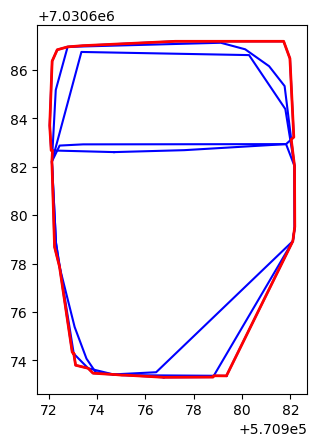

In [23]:
footprints = [f["footprint_2d"] for f in roof_facets]
roof_footprint_2d = unary_union(footprints)

print("Sammenslått footprint type:", roof_footprint_2d.geom_type)

fig, ax = plt.subplots()
for f in roof_facets:
    x, y = f["footprint_2d"].exterior.xy
    ax.plot(x, y, "b-")

if roof_footprint_2d.geom_type == "Polygon":
    x, y = roof_footprint_2d.exterior.xy
    ax.plot(x, y, "r-", linewidth=2)

ax.set_aspect("equal", "box")
plt.show()


In [24]:
def lift_polygon_to_plane(poly, plane):
    """
    poly: shapely Polygon (2D)
    plane: (a, b, c, d) for ax + by + cz + d = 0
    """
    a, b, c, d = plane
    coords_3d = []
    for x, y in poly.exterior.coords:
        z = (-a*x - b*y - d) / c
        coords_3d.append((x, y, z))
    return coords_3d

roof_facets_3d = []
for f in roof_facets:
    poly2d = f["footprint_2d"]
    plane = f["plane"]
    poly3d = lift_polygon_to_plane(poly2d, plane)
    f["polygon_3d"] = poly3d
    roof_facets_3d.append(poly3d)

len(roof_facets_3d), roof_facets_3d[0][:3]


(4,
 [(570974.71, 7030682.61, np.float64(99.99017278540977)),
  (570972.4400000001, 7030682.67, np.float64(99.92966726701891)),
  (570972.11, 7030682.68, np.float64(99.92027628272278))])

In [25]:
ground_z = float(np.min(points[:, 2])) - 2 # trekk 2 meter for å få terreng under bygningen
print("Estimert terrenghøyde:", ground_z)

# Bruk sammenslått footprint til vegger
if roof_footprint_2d.geom_type == "Polygon":
    wall_base_poly = roof_footprint_2d
else:
    # ta f.eks. største polygon hvis MultiPolygon
    wall_base_poly = max(list(roof_footprint_2d.geoms), key=lambda p: p.area)

wall_quads = []
coords2d = list(wall_base_poly.exterior.coords)

# For veggene bruker vi felles "gesims-høyde".
avg_roof_edge_z = float(np.median([p[2] for facet in roof_facets_3d for p in facet]))

for i in range(len(coords2d)-1):
    x1, y1 = coords2d[i]
    x2, y2 = coords2d[i+1]

    quad = [
        (x1, y1, ground_z),
        (x1, y1, avg_roof_edge_z),
        (x2, y2, avg_roof_edge_z),
        (x2, y2, ground_z)
    ]
    wall_quads.append(quad)

print("Antall veggflater:", len(wall_quads))


Estimert terrenghøyde: 95.74000000000001
Antall veggflater: 31


In [26]:
lod2_model = {
    "roof_facets": roof_facets_3d,        # liste av lister med 3D-koordinater
    "roof_type": roof_type,
    "ridge_lines_2d": [
        list(r["line"].coords) for r in ridge_lines
    ],
    "footprint_2d": list(wall_base_poly.exterior.coords),
    "walls": wall_quads,
    "ground_z": ground_z,
    "file": LAZ_FILE,
}

import json
with open("lod2_model_from_10444144.json", "w") as f:
    json.dump(lod2_model, f, indent=2)

lod2_model["roof_type"], len(lod2_model["roof_facets"]), len(lod2_model["walls"])


('Komplekst tak', 4, 31)

In [28]:
import open3d as o3d
import numpy as np

geoms = []

# Takfasetter som MeshLine
for facet in roof_facets_3d:
    pts = np.array(facet)
    # lag linjer rundt poly
    lines = [[i, i+1] for i in range(len(pts)-1)]
    ls = o3d.geometry.LineSet()
    ls.points = o3d.utility.Vector3dVector(pts)
    ls.lines = o3d.utility.Vector2iVector(lines)
    geoms.append(ls)

# Vegger som LineSet
for quad in wall_quads:
    pts = np.array(quad + [quad[0]])  # lukk
    lines = [[i, i+1] for i in range(len(pts)-1)]
    ls = o3d.geometry.LineSet()
    ls.points = o3d.utility.Vector3dVector(pts)
    ls.lines = o3d.utility.Vector2iVector(lines)
    geoms.append(ls)

o3d.visualization.draw_geometries(geoms)
